# Loading STLs
We decided to use Python3D to load stls.
I used (BAIR Lab's?) jaxrl conda environment to run this notebook. I also built Python3D from source using github.
Here is the command I ran to build Python3D from source:

In [1]:
! pip install "git+https://github.com/facebookresearch/pytorch3d.git"

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-p74lcq1u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-p74lcq1u
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 055ab3a2e3e611dff66fa82f632e62a315f3b5e7
  Preparing metadata (setup.py) ... done


## Step 1: Import Pytorch3D
Imports are below:

In [104]:
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
import trimesh
! wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
trg_obj = 'dolphin.obj'
device = 'cuda:0'
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)
remeshed = trimesh.Trimesh(vertices=verts, faces=faces.verts_idx)

# Visualize the remeshed surface
remeshed.show()

# Save the remeshed surface as an STL file
remeshed.export("test.stl")

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

--2024-12-09 03:03:13--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.51, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.22’

dolphin.obj.22      100%[===================>] 153.09K  --.-KB/s    in 0.09s   

2024-12-09 03:03:14 (1.62 MB/s) - ‘dolphin.obj.22’ saved [156763/156763]



/home/jess/anaconda3/envs/jaxrl/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [100]:
import numpy as np
import trimesh
from scipy.spatial import Delaunay
import numpy as np
import trimesh

from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
import numpy as np


points = sample_points_from_meshes(trg_mesh, 5000)
x, z, y = points.clone().detach().cpu().squeeze().unbind(1)  
x = [int((p + 1) * 200) for p in x]
y = [int((p + 1) * 200) for p in y]
z = [int((p + 1) * 200) for p in z]
# breakpoint()
y_flipped = np.negative(y) 

# Combine points into a 2D array for Delaunay triangulation
xy = np.column_stack((x, y))  # Use x, y as 2D plane for triangulation

# Perform Delaunay triangulation
tri = Delaunay(xy)
faces = tri.simplices  # Triangulated faces

# Create a Trimesh object for the remeshed surface
vertices = np.column_stack((x, y, z))
remeshed = trimesh.Trimesh(vertices=vertices, faces=faces)

# Visualize the remeshed surface
remeshed.show()

# Save the remeshed surface as an STL file
remeshed.export("remeshed_surface.stl")

# Load the STL file
mesh = trimesh.load("remeshed_surface.stl")


ray_origins = []
ray_directions = []
max_z = 500

for i in range(401):
    for j in range(401):
        ray_origins.append([i, j, max_z])
        ray_directions.append([0, 0, -1])

ray_origins = np.array(ray_origins)
ray_directions = np.array(ray_directions)

# mesh = trimesh.load("sample_meshes/Sample_Crimp_8.stl")
intersection_mesh = trimesh.ray.ray_triangle.RayMeshIntersector(mesh)

intersections = intersection_mesh.intersects_location(np.array(ray_origins), np.array(ray_directions))

locations = intersections[0]
ray_indices = intersections[1]
# print(ray_indices.shape[0])

max = -1000
max_pts = []
# print(np.unique(ray_origins))
for ray_index in ray_indices:
    ri = ray_indices == ray_index
    # print(np.unique(ri))
    masked_locations = locations[ri]
    # print(masked_locations)
    max = -np.inf
    max_pt = []
    for location in masked_locations:
        if (location[2] > max):
            max = location[2]
            max_pt = location
    if (max_pt[2] > 2):
        max_pts.append(max_pt)

hull = trimesh.convex.convex_hull(max_pts)

# Export the STL file
hull.export("point_cloud_to_stl.stl")


# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# x = [int(p[0]) for p in max_pts]
# y = [int(p[1]) for p in max_pts]
# z = [int(p[2]) for p in max_pts]

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=50)  # Color by z-values



# height_map = np.zeros((401,401))

# for i in range(len(x)):
#     # print([x[i]])
#     # print(y[i])
#     height_map[x[i]][y[i]] = z[i]


# from scipy.ndimage import gaussian_filter

# # # Smooth the height map using Gaussian filter
# # sigma = 2.5  # Control the smoothing level (higher sigma = more smoothing)
# # height_map = gaussian_filter(height_map, sigma=sigma)

# from scipy.ndimage import median_filter

# # height_map = median_filter(height_map, size=3)

# from scipy.ndimage import zoom

# from scipy.interpolate import RBFInterpolator
# # # Downsample and upsample the height map
# # downsample_factor = 0.1  # Smaller values lead to more smoothing
# # downsampled = zoom(height_map, downsample_factor)
# # height_map = zoom(downsampled, 1 / downsample_factor)

# # Generate grid coordinates
# x = np.arange(height_map.shape[1])
# y = np.arange(height_map.shape[0])
# X, Y = np.meshgrid(x, y)

# from scipy.interpolate import griddata

# # Flatten grid and values
# points = np.column_stack((X.ravel(), Y.ravel()))
# values = height_map.ravel()

# # Use cubic interpolation to smooth the surface
# smoothed_Z = griddata(points, values, (X, Y), method='cubic')

# # Flatten grid and smoothed surface to create vertices
# vertices = np.column_stack((X.ravel(), Y.ravel(), smoothed_Z.ravel()))

# # Create faces by connecting adjacent vertices (grid triangulation)
# faces = []
# rows, cols = smoothed_Z.shape
# for i in range(rows - 1):
#     for j in range(cols - 1):
#         v0 = i * cols + j
#         v1 = v0 + 1
#         v2 = v0 + cols
#         v3 = v2 + 1
#         faces.append([v0, v1, v2])  # Triangle 1
#         faces.append([v1, v3, v2])  # Triangle 2

# # Create the Trimesh object
# mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# # Export the smoothed STL file
# mesh.export("smoothed_surface.stl")

# x = np.arange(height_map.shape[0]) 
# y = np.arange(height_map.shape[1]) 
# X, Y = np.meshgrid(x, y)  

# Z = height_map


# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=45, azim=0)

# x_pos = X.ravel()
# y_pos = Y.ravel()
# z_pos = np.zeros_like(x_pos) 
# dx = dy = 1  
# dz = Z.ravel()  

# ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True, cmap='viridis')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# max_pts = np.array(max_pts)
# print(max_pts.shape)


# # Create a Matplotlib 3D plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Plot the mesh
# ax.plot_trisurf(
#     mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
#     triangles=mesh.faces, cmap="viridis", edgecolor="none"
# )

# # Set labels
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# plt.title("STL Visualization")

# # Save the figure as an image
# plt.savefig("stl_visualization.png")
# plt.show()


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00:\x01\x00\x00\xc4\xb3h?r\xc9\x84\xbe_\x10\xa7>\x00\x00\x89C\x00\x00\x80C\x00\x00/C\x00\x00HC\x00\x00\x02C\x00\x80\x8cC\x00\x00}C\x00\x00\xa0@\x01\x00\x08B\x00\x00\x1f\x16g\xbft\xeb\x89\xbe,\xcf\xab>\x00\x00\x12C\x00\x00\xe0@\x00\x00\x14B\x00\x00HC\x00\x00\x02C\x00\x80\x8cC\x00\x00\xf6B\x00\x00{C\x00\x00+C\x00\x00#oL?&\x9a\xe6\xbe2o\xcc>\x00\x00|C\x00\x00\xa0@\x00\x00\x10B\x00\x00}C\x00\x00\xa0@\x01\x00\x08B\x00\x00HC\x00\x00\x02C\x00\x80\x8cC\x00\x002\xea\xa4>\xa2YP\xbf\xc1\x9a\xf7>\x00\x00HC\x00\x00\x02C\x00\x80\x8cC\x00\x00HC\x00\x00@B\x00\x00\x0fC\x00\x00|C\x00\x00\xa0@\x00\x00\x10B\x00\x00k\x8e\xb9=\\G\xf2>\x17T`\xbf\x00\x00}C\x00\x00\xa0@\x01\x00\x08B\x00\x00GC\x00

In [55]:
import numpy as np
import trimesh

from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
import numpy as np

points = sample_points_from_meshes(trg_mesh, 5000)
x, z, y = points.clone().detach().cpu().squeeze().unbind(1)  
x = [int((p + 1) * 100) for p in x]
y = [int((p + 1) * 100) for p in y]
z = [int((p + 1) * 100) for p in z]
# breakpoint()
y_flipped = np.negative(y) 

ray_origins = []
ray_directions = []

for i in range(201):
    for j in range(201):
        ray_origins.append([i, j, np.inf])
        ray_directions.append([0, 0, -1])

intersection_mesh = trimesh.ray.ray_triangle.RayMeshIntersector(mesh)

intersections = intersection_mesh.intersects_location(np.array(ray_origins), np.array(ray_directions))

locations = intersections[0]
ray_indices = intersections[1]

max = -np.inf
max_pts = []
for i in range(ray_origins.shape[0]):
    ray_index = ray_indices == i
    masked_locations = locations[ray_index]
    max = -10000
    max_pt = []
    for location in masked_locations:
        if (location[2] > max):
            max = location[2]
            max_pt = location
    max_pts.append(max_pt)

x = [p[0] for p in max_pts]
y = [p[1] for p in max_pts]
z = [p[2] for p in max_pts]


height_map = np.zeros((201,201))

# for index_x, x_elem in enumerate(x):
#     for index_z, z_elem in enumerate(z):
#         height_map[x_elem][z_elem] = y[index_z]


for i in range(height_map.shape[0]):
    height_map[x[i]][y[i]] = z[i]
np.set_printoptions(threshold=100)
print(np.array(height_map))

x = np.array(x)
y = np.array(y)
z = np.array(z)


x = np.arange(height_map.shape[0]) 
y = np.arange(height_map.shape[1]) 
X, Y = np.meshgrid(x, y)  

Z = height_map

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45, azim=45)

x_pos = X.ravel()
y_pos = Y.ravel()
z_pos = np.zeros_like(x_pos) 
dx = dy = 1  
dz = Z.ravel()  

ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



/home/jess/anaconda3/envs/jaxrl/lib/python3.10/site-packages/trimesh/ray/ray_triangle.py:390: RuntimeWarning: invalid value encountered in multiply
  on_a = (ray_directions * t_a) + ray_origins
/home/jess/anaconda3/envs/jaxrl/lib/python3.10/site-packages/trimesh/ray/ray_triangle.py:390: RuntimeWarning: invalid value encountered in add
  on_a = (ray_directions * t_a) + ray_origins
/home/jess/anaconda3/envs/jaxrl/lib/python3.10/site-packages/trimesh/ray/ray_triangle.py:391: RuntimeWarning: invalid value encountered in multiply
  on_b = (ray_directions * t_b) + ray_origins
/home/jess/anaconda3/envs/jaxrl/lib/python3.10/site-packages/trimesh/ray/ray_triangle.py:391: RuntimeWarning: invalid value encountered in add
  on_b = (ray_directions * t_b) + ray_origins


RTreeError: Coordinates must not have minimums more than maximums

61
137
-190
0
18
140
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(5000,)
(5000,)
(5000,)


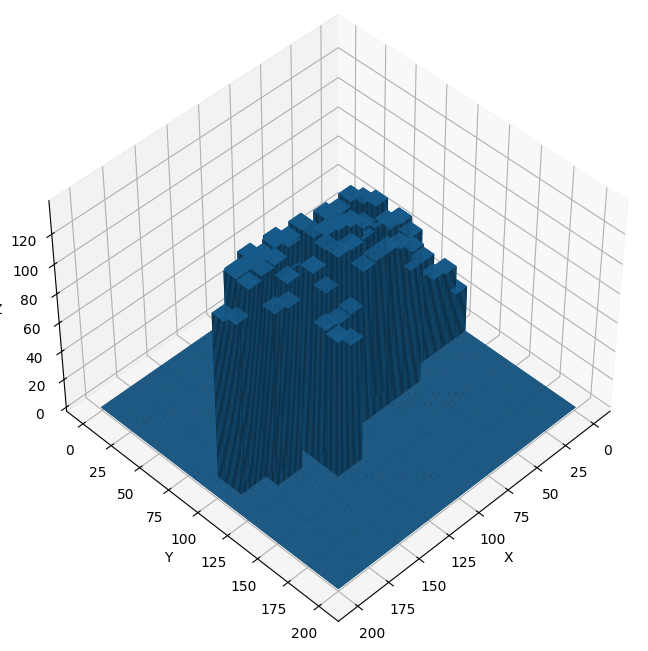

In [ ]:
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
import numpy as np
points = sample_points_from_meshes(trg_mesh, 5000)
x, z, y = points.clone().detach().cpu().squeeze().unbind(1)  
x = [int((p + 1) * 100) for p in x]
y = [int((p + 1) * 100) for p in y]
z = [int((p + 1) * 100) for p in z]
# breakpoint()
y_flipped = np.negative(y) 
x_min = min(x)
x_max = max(x)
y_min = min(y_flipped)
y_max = max(y_flipped)
z_min = min(z)
z_max = max(z)
print(x_min)
print(x_max)
print(y_min)
print(y_max)
print(z_min)
print(z_max)
np.set_printoptions(threshold=np.inf)

height_map = np.zeros((201,201))

# for index_x, x_elem in enumerate(x):
#     for index_z, z_elem in enumerate(z):
#         height_map[x_elem][z_elem] = y[index_z]


for i in range(height_map.shape[0]):
    height_map[x[i]][y[i]] = z[i]
np.set_printoptions(threshold=100)
print(np.array(height_map))

x = np.array(x)
y = np.array(y)
z = np.array(z)

print(x.shape)
print(y.shape)
print(z.shape)



def plot_pointcloud(x, y, z, title=""):
    # Sample points uniformly from the surface of the mesh.
    # points = sample_points_from_meshes(mesh, 5000)
    # x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(-x, -y, z)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev=10, azim=0)

import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# # Perform bicubic interpolation
# height_map = zoom(height_map, scale_factor, order=3)  # order=3 is bicubic interpolation
# #     plt.show()

# plot_pointcloud(np.array(x), np.array(y), np.array(z), "Target mesh")

bin_size = 10  # E.g., process every 5 columns

# Initialize an array to store the maximums
max_values_map = np.zeros_like(height_map)

for i in range(0, height_map.shape[0], bin_size):
    for j in range(0, height_map.shape[1], bin_size):
        # Define bin boundaries
        x_start, x_end = i, min(i + bin_size, height_map.shape[0])
        y_start, y_end = j, min(j + bin_size, height_map.shape[1])
        
        # Extract the current bin
        bin_slice = height_map[x_start:x_end, y_start:y_end]
        
        # Find the maximum value in the bin
        max_value = np.max(bin_slice)
        
        # Assign the maximum value to all positions in the bin
        max_values_map[x_start:x_end, y_start:y_end] = max_value

from scipy.ndimage import gaussian_filter

# Smooth the height map using Gaussian filter
sigma = 10  # Control the smoothing level (higher sigma = more smoothing)
smoothed_height_map = gaussian_filter(max_values_map, sigma=sigma)


# # Desired upscale factor (e.g., 5 for 1000x1000)
# scale_factor = 3
# max_values_map = zoom(max_values_map, scale_factor, order=3)  # order=3 is bicubic interpolation
# #     plt.show()

x = np.arange(max_values_map.shape[0]) 
y = np.arange(max_values_map.shape[1]) 
X, Y = np.meshgrid(x, y)  

Z = max_values_map

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45, azim=45)

x_pos = X.ravel()
y_pos = Y.ravel()
z_pos = np.zeros_like(x_pos) 
dx = dy = 1  
dz = Z.ravel()  

ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

from scipy.interpolate import Rbf
# epsilon = 1e-5 # Small value
# regularized_x = x + epsilon * np.eye(x.shape[0])
# inv_regularized_x = np.linalg.inv(regularized_x)
# regularized_y = y + epsilon * np.eye(y.shape[0])
# inv_regularized_y = np.linalg.inv(regularized_y)
# regularized_z = z + epsilon * np.eye(z.shape[0])
# inv_regularized_z = np.linalg.inv(regularized_z)
# breakpoint()


In [ ]:
import numpy as np
import trimesh

# # Assuming `height_map` is a 2D numpy array
# x = np.arange(height_map.shape[1])
# y = np.arange(height_map.shape[0])
# X, Y = np.meshgrid(x, y)
# Z = height_map

# Flatten the grid to create vertices
vertices = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))



# Create faces by connecting adjacent vertices (grid triangulation)
faces = []
rows, cols = height_map.shape
for i in range(rows - 1):
    for j in range(cols - 1):
        v0 = i * cols + j
        v1 = v0 + 1
        v2 = v0 + cols
        v3 = v2 + 1
        faces.append([v0, v1, v2])  # Triangle 1
        faces.append([v1, v3, v2])  # Triangle 2

# Create a Trimesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

import numpy as np
from scipy.ndimage import gaussian_filter
import trimesh

# Example height map
height_map = np.random.rand(100, 100) * 10  # Replace with your actual height map

# Apply Gaussian smoothing
smoothed_height_map = gaussian_filter(height_map, sigma=2)  # Adjust sigma for more/less smoothing

# Create the mesh as before
x = np.arange(smoothed_height_map.shape[1])
y = np.arange(smoothed_height_map.shape[0])
X, Y = np.meshgrid(x, y)
Z = smoothed_height_map

# Flatten the grid to create vertices
vertices = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

# Create faces by connecting adjacent vertices (grid triangulation)
faces = []
rows, cols = smoothed_height_map.shape
for i in range(rows - 1):
    for j in range(cols - 1):
        v0 = i * cols + j
        v1 = v0 + 1
        v2 = v0 + cols
        v3 = v2 + 1
        faces.append([v0, v1, v2])  # Triangle 1
        faces.append([v1, v3, v2])  # Triangle 2

# Create a Trimesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Export the STL file
# mesh.export("smooth_height_map.stl")
# Apply Laplacian smoothing
smoothed_mesh = mesh.copy()
smoothed_mesh.vertices[:, 2] = gaussian_filter(smoothed_mesh.vertices[:, 2], sigma=1)

# Export the STL file
mesh.export("height_map.stl")


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x92L\x00\x00$m\xc4=\xe7>l=Dd~?\x00\x00\x00\x00\x00\x00\x00\x00w\x03\xe1@\x00\x00\x80?\x00\x00\x00\x00\xcb\xec\xdd@\x00\x00\x00\x00\x00\x00\x80?\xfc\'\xdf@\x00\x00\x1a\x07\xb5=-FM=\xcc\xac~?\x00\x00\x80?\x00\x00\x00\x00\xcb\xec\xdd@\x00\x00\x80?\x00\x00\x80?\x1cP\xdc@\x00\x00\x00\x00\x00\x00\x80?\xfc\'\xdf@\x00\x00u;1>{\xf8J=0\xd1{?\x00\x00\x80?\x00\x00\x00\x00\xcb\xec\xdd@\x00\x00\x00@\x00\x00\x00\x00bK\xd8@\x00\x00\x80?\x00\x00\x80?\x1cP\xdc@\x00\x00\xdf?">\x91q\r=\x88\x9c|?\x00\x00\x00@\x00\x00\x00\x00bK\xd8@\x00\x00\x00@\x00\x00\x80?\xb3,\xd7@\x00\x00\x80?\x00\x00\x80?\x1cP\xdc@\x00\x00X1\\>\xf2\xe6\x0b=\xc3\xdby?\x00\x00\x00@\x00\x00\x00\x00bK\xd8@\x00\x00@@\x00\x0

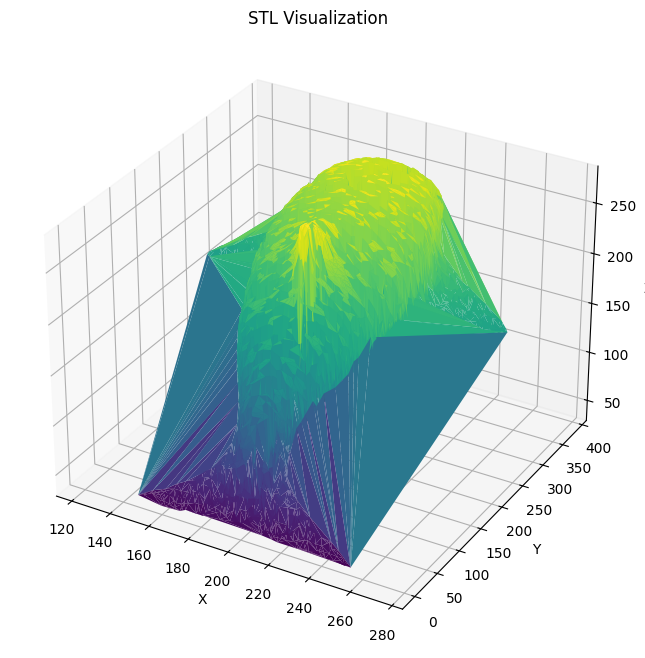

In [102]:
import trimesh
import matplotlib.pyplot as plt

# Load the STL file
mesh = trimesh.load("remeshed_surface.stl")

# Create a Matplotlib 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(
    mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
    triangles=mesh.faces, cmap="viridis", edgecolor="none"
)

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("STL Visualization")

# Save the figure as an image
plt.savefig("stl_visualization.png")
plt.show()


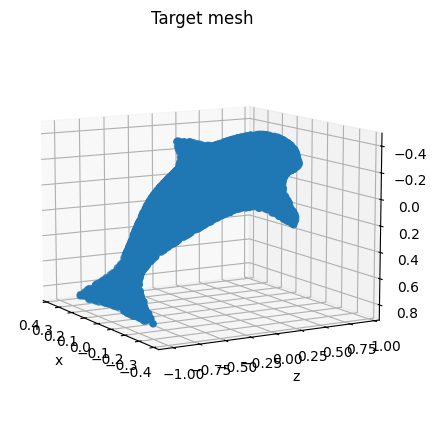

torch.Size([2562, 3])
tensor(-0.3814, device='cuda:0')
tensor(0.3757, device='cuda:0')
tensor(-1., device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(-0.4110, device='cuda:0')
tensor(0.8304, device='cuda:0')


In [51]:
import numpy as np
plot_pointcloud(points, "Target mesh")
print(trg_mesh.verts_packed().shape)
verts = trg_mesh.verts_packed()
verts = [(vert[0], vert[2], -vert[1]) for vert in verts]
verts_x = [vert[0] for vert in verts]
verts_y = [vert[1] for vert in verts]
verts_z = [vert[2] for vert in verts]
x_min = min(verts_x)
x_max = max(verts_x)
y_min = min(verts_y)
y_max = max(verts_y)
z_min = min(verts_z)
z_max = max(verts_z)
print(x_min)
print(x_max)
print(y_min)
print(y_max)
print(z_min)
print(z_max)

# height_map = np.zeros((len(range(x_min,x_max))))